## models download

In [ ]:
import requests
import tarfile
import sys
import os
sys.path.append("..")

In [5]:
def download_kaggle_model(model_name, model_type, url, path="../models"):
    # Download a model from Kaggle
    response = requests.get(url)
    if response.status_code == 200:
        with open(f"{path}/{model_type}/{model_name}.tar.gz", "wb") as f:
            f.write(response.content)

        # unzip the preprocessor
        with tarfile.open(f"{path}/{model_type}/{model_name}.tar.gz", "r:gz") as tar:
            tar.extractall(path=f"{path}/{model_type}/{model_name}")
            print("Preprocessor extracted successfully.")

        # remove the tar.gz file
        os.remove(f"{path}/{model_type}/{model_name}.tar.gz")
    else:
        print(f"Failed to download {model_type} model: {response.status_code}")
    

In [6]:
preprocessor_inputs = {
    "model_name": "en_uncased_preprocess",
    "model_type": "preprocessor",
    "url": "https://www.kaggle.com/api/v1/models/tensorflow/bert/tensorFlow2/en-uncased-preprocess/3/download"
}

encoder_inputs = {
    "model_name": "cmlm-en-base",
    "model_type": "encoder",
    "url": "https://www.kaggle.com/api/v1/models/google/universal-sentence-encoder/tensorFlow2/cmlm-en-base/1/download"
}

In [9]:
download_kaggle_model(**encoder_inputs)

Preprocessor extracted successfully.


## chunk embeddings

In [1]:
import json
import tensorflow_hub as hub
import tensorflow_text as tftext
import tensorflow as tf

import sys
sys.path.append("..")

# check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")

2025-06-21 17:26:38.100295: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-21 17:26:38.118863: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-21 17:26:38.140922: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-21 17:26:38.147064: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-21 17:26:38.162274: I tensorflow/core/platform/cpu_feature_guar

GPU is available.


I0000 00:00:1750519600.705399    9081 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1750519600.778310    9081 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1750519600.778377    9081 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.


In [38]:
chunks_path = '../chunk_eval_results'
eval_file = "2502.09625v1"
query_idx = 1

with open(f'{chunks_path}/{eval_file}_{query_idx}.json', "r") as f:
    eval_metadata = json.load(f)

In [5]:
preprocessor = hub.load('../models/preprocessor/en_uncased_preprocess')

In [39]:
chunks = [chunk_spec['text'] for chunk_spec in eval_metadata['chunks_eval']]
chunks_idxs = [chunk_spec['idx'] for chunk_spec in eval_metadata['chunks_eval']]
chunks_labels = [chunk_spec['label'] for chunk_spec in eval_metadata['chunks_eval']]

query = eval_metadata['query']

In [7]:
tokenizer = hub.KerasLayer(preprocessor.tokenize)
inputer = hub.KerasLayer(preprocessor.bert_pack_inputs, 
                         arguments=dict(seq_length=256)
                         )

In [40]:
tokenized_inputs = tokenizer(chunks + [query])
encoder_inputs = inputer([tokenized_inputs])

print(f"endoder inputs: {', '.join([key for key in encoder_inputs.keys()])}")
max_seq = tf.reduce_max(tf.reduce_sum(encoder_inputs['input_mask'], axis=1)).numpy()
print(f'Max sequence length: {max_seq}')

endoder inputs: input_type_ids, input_mask, input_word_ids
Max sequence length: 245


In [9]:
encoder = hub.KerasLayer('../models/encoder/cmlm-en-base')

In [41]:
encoder_output = encoder(encoder_inputs)['pooled_output']
print(f"Encoder output shape: {encoder_output.shape}")

encoded_chunks = encoder_output[:-1]
encoded_query = encoder_output[-1:]
print(f"Encoded chunks shape: {encoded_chunks.shape}")
print(f"Encoded query shape: {encoded_query.shape}")

Encoder output shape: (60, 768)
Encoded chunks shape: (59, 768)
Encoded query shape: (1, 768)


In [44]:
encoder_inputs

{'input_type_ids': <tf.Tensor: shape=(60, 256), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(60, 256), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_word_ids': <tf.Tensor: shape=(60, 256), dtype=int32, numpy=
 array([[  101, 10938,  2121, ...,     0,     0,     0],
        [  101,  1996,  3006, ...,     0,     0,     0],
        [  101,  5248,  1997, ...,     0,     0,     0],
        ...,
        [  101,  4518,  7597, ...,     0,     0,     0],
        [  101,  1999, 15756, ...,     0,     0,     0],
        [  101,  2129,  2515, ...,     0,     0,

In [35]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline

def plot_embeddings_2d(embeddings, query_embeddings=None, labels=None, idxs=None):
    """
    Reduce dimensionality of embeddings and plot them on a 2D scatter plot.

    Args:
        embeddings (np.ndarray): Encoded sentences with shape [seq_length, vector_size].
        labels (list, optional): Labels for each point in the plot (True/False). Defaults to None.
        idxs (list, optional): Indices for each point in the plot. Defaults to None.
    """
    # Reduce dimensionality to 2D using PCA
    pca = PCA(n_components=2)
    pca = pca.fit(embeddings)
    reduced_embeddings = pca.transform(embeddings)

    # Determine colors based on labels
    colors = ['green' if label else 'red' for label in labels] if labels else 'blue'

    # Create scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=colors, alpha=0.7)
    if query_embeddings is not None:
        reduced_query = pca.transform(query_embeddings)
        plt.scatter(reduced_query[:, 0], reduced_query[:, 1], c='black', marker='x', s=100, label='Query', alpha=0.7)

    # Add indices as text if provided
    if idxs:
        for i, idx in enumerate(idxs):
            plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], str(idx), fontsize=9)

    plt.title("2D Scatter Plot of Embeddings")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.show()

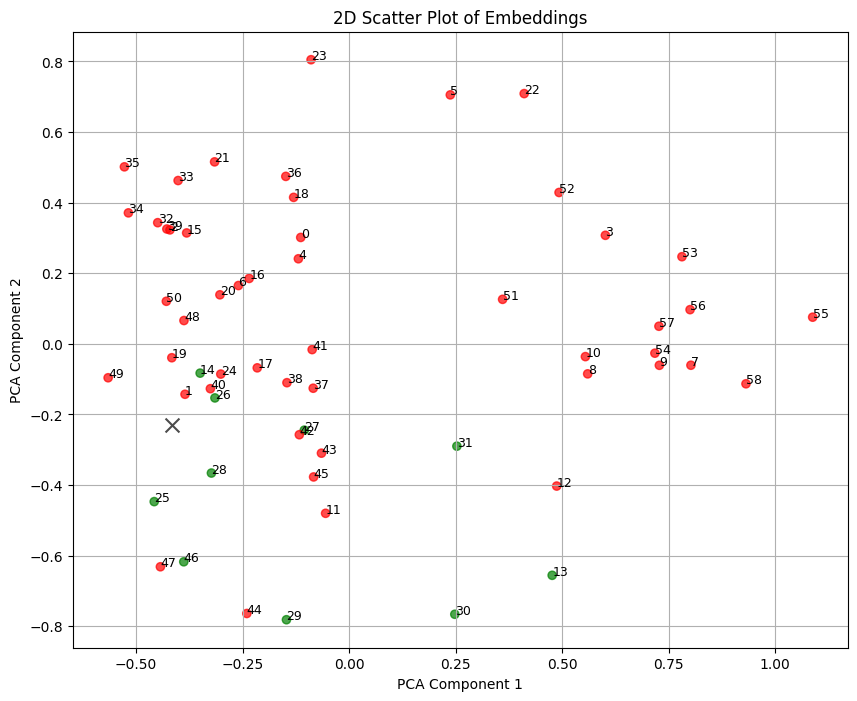

In [42]:
plot_embeddings_2d(encoded_chunks.numpy(), query_embeddings=encoded_query.numpy(), labels=chunks_labels, idxs=chunks_idxs)

In [15]:
from tensorflow_models import nlp

In [45]:
decoder = nlp.models.TransformerDecoder(
    num_layers=2,
    num_attention_heads=8,
    intermediate_size=512,
    activation='relu',
    dropout_rate=0.1,
    use_bias=False,
    norm_first=True
)

In [48]:
preds = decoder(target=encoded_chunks[tf.newaxis], memory=encoded_query[tf.newaxis])

In [49]:
preds

<tf.Tensor: shape=(1, 59, 768), dtype=float32, numpy=
array([[[-0.16022277, -0.765825  , -0.01735011, ..., -1.2105156 ,
         -0.09360345, -1.0493406 ],
        [-0.13948695, -0.77545756, -0.09612821, ..., -1.2415701 ,
         -0.10303123, -0.9412316 ],
        [-0.10531109, -0.9617486 , -0.13466711, ..., -1.325211  ,
          0.08335153, -1.1471006 ],
        ...,
        [-0.13225968, -0.7264893 ,  0.17529753, ..., -1.1439389 ,
         -0.08257533, -1.0666366 ],
        [ 0.0357746 , -0.927553  ,  0.2370688 , ..., -1.2777513 ,
         -0.08223972, -1.1605666 ],
        [-0.10317465, -0.8921122 ,  0.36901495, ..., -1.3713669 ,
         -0.12849428, -1.1571046 ]]], dtype=float32)>

In [19]:
decoder.get_config()

{'name': 'transformer_decoder',
 'trainable': True,
 'dtype': 'float32',
 'num_layers': 6,
 'num_attention_heads': 8,
 'intermediate_size': 2048,
 'activation': 'relu',
 'dropout_rate': 0.0,
 'attention_dropout_rate': 0.0,
 'use_bias': False,
 'norm_first': True,
 'norm_epsilon': 1e-06,
 'intermediate_dropout': 0.0,
 'self_attention_cls': None,
 'cross_attention_cls': None}

## save tfrec

In [ ]:
def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def serialize_example(self, names, inputs):
        feature = {name: self._bytes_feature(tf.io.serialize_tensor(x)) for name, x in zip(names, inputs)}

        example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
        return example_proto.SerializeToString()